## **Project Overview**

### **Topic:** Image Captioning with VGG16 Feature Extraction and LSTM Decoder

### **Introduction**

This project focuses on building an image captioning model using the Flickr8k dataset, which consists of 8,000 images, each paired with five captions. The dataset contains images and a separate captions file, which links images to their corresponding descriptions. The objective is to generate descriptive captions for images using deep learning techniques, particularly leveraging the VGG16 pretrained model for feature extraction and an LSTM (Long Short-Term Memory) network for sequence generation.

### **Methodology**

#### **Feature Extraction**

To extract features from the images, we use the VGG16 model, pretrained on ImageNet. The final layer of the model is removed, leaving the fully connected layers which are used for image feature representation. The images in the dataset are normalized, resized to 224x224 pixels, and the pixel values are preprocessed before being passed through the VGG16 model to extract features.

#### **Caption Preprocessing**

The captions are cleaned (converted to lowercase, special characters removed, and unnecessary spaces removed), and tokenized for further processing. The captions are transformed into sequences of words, each word assigned a unique integer identifier based on its frequency. The captions are split into training and testing datasets. A custom data generator is created to yield batches of image features and caption sequences for model training. The sequences are padded and one-hot encoded to prepare them for input into the LSTM model.

#### **Model Architecture**

The model consists of two parts:

1. ***Image Feature Layer***: This layer processes the features extracted from the images using the VGG16 model. It includes a dense layer with dropout for regularization.

2. ***Caption Generation Layer***: This layer processes the tokenized caption sequences with an LSTM layer to capture the temporal dependencies between words in the caption.

The two parts are merged, and a final dense layer with a softmax activation function is used to generate the predicted words in the caption.

#### **Evaluation**

The model is trained using categorical cross-entropy loss and the Adam optimizer. After training the model, captions are predicted for the test dataset images. The predicted captions are compared with the actual captions using the BLEU score. The BLEU-1 and BLEU-2 scores measure the similarity of the predicted captions to the ground truth captions at different n-gram levels. To generate captions for unseen images, the model uses a sequence generation approach where the predicted word is appended to the input sequence, and the process repeats until the end token (endseq) is generated.


## **Implementation**

#### **Load Data**

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d adityajn105/flickr8k

! unzip "flickr8k.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

#### **Extract Features**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

feature_extractor = VGG16()

feature_extractor = Model(inputs = feature_extractor.inputs, outputs = feature_extractor.layers[-2].output)

feature_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

features = {}

for img_name in tqdm(os.listdir('Images')):
    img_path = 'Images/' + img_name
    image = load_img(img_path, target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = feature_extractor.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature.squeeze()

print(f"Extracted features for {len(features)} images.")

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Extracted features for 8091 images.


#### **Clean and Map Captions**

In [ ]:
with open('captions.txt', 'r') as f:
  next(f)
  captions = f.read()

mapped_data = {}

for line in tqdm(captions.split('\n')):
  subs = line.split(',')

  if len(subs) < 2: continue

  image_id, caption = subs[0], subs[1:]

  image_id = image_id.split('.')[0]

  caption = ' '.join(caption)

  if image_id not in mapped_data:
    mapped_data[image_id] = []

  mapped_data[image_id].append(caption)

for key, captions in mapped_data.items():
  for i in range(len(captions)):
    caption = captions[i].lower()
    # caption = caption.lower()
    caption = caption.replace('[^A-Za-z]', '')
    caption = caption.replace('\s+', ' ')
    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
    captions[i] = caption

captions = [caption for key in mapped_data for caption in mapped_data[key]]

  0%|          | 0/40456 [00:00<?, ?it/s]

#### **Tokenize**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

# Get maximum length
max_length = max(len(caption.split()) for caption in captions)
print("Vocabulary Size:", vocab_size)
print("Max Length:", max_length)

Vocabulary Size: 8485
Max Length: 35


#### **Split Data**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Split data
image_ids = list(mapped_data.keys())
split_index = int(len(image_ids) * 0.90)
train = image_ids[:split_index]
test = image_ids[split_index:]

# Data generator
def data_generator(data_keys, mapped_data, features, tokenizer, max_length, vocab_size, batch_size):
  X1 = []
  X2 = []
  y = []
  n = 0
  while True:
    for key in data_keys:
      n += 1
      captions = mapped_data[key]

      for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(sequence)):
          input_seq, output_seq = sequence[:i], sequence[i]

          input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')[0]

          output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

          X1.append(features[key])
          X2.append(input_seq)
          y.append(output_seq)

          if n == batch_size:
              yield (np.array(X1), np.array(X2)), np.array(y)
              X1, X2, y = [], [], []
              n = 0

#### **Encoder-Decoder**

In [ ]:
from tensorflow.keras.layers import Input , Dense , Embedding , LSTM , Dropout , add

# Encoder
# Image features layers
feat_input = Input(shape=(4096,))
feat_layer1 = Dropout(0.4)(feat_input)
feat_layer2 = Dense(256, activation = 'relu')(feat_layer1)

# Sequence feature layers
seq_input = Input(shape=(max_length,))
seq_layer1 = Embedding(vocab_size, 256, mask_zero = True)(seq_input)
seq_layer2 = Dropout(0.4)(seq_layer1)
seq_layer3 = LSTM(256)(seq_layer2)

# Decoder
decoder1 = add([feat_layer2 ,seq_layer3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
output_layer = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[feat_input, seq_input], outputs = output_layer)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

output_signature = ((tf.TensorSpec(shape=(None, 4096), dtype=tf.float32), tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
                    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32))

def generate_data(data_keys, mapped_data, features, tokenizer, max_length, vocab_size, batch_size):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(data_keys, mapped_data, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )

#### **Train Model**

In [ ]:
import numpy as np

epochs = 35
batch_size = 32
steps = len(train) // batch_size

train_dataset = generate_data(train, mapped_data, features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 240ms/step - loss: 5.8076
Epoch 2/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 4.0985
Epoch 3/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 211ms/step - loss: 3.6117
Epoch 4/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - loss: 3.3316
Epoch 5/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - loss: 3.1243
Epoch 6/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - loss: 2.9628
Epoch 7/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - loss: 2.8457
Epoch 8/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 2.7507
Epoch 9/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 2.6667
Epoch 10/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - loss: 2.5925
Epoch 11/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - loss: 2.5321
Epoch 12/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 2.4778
Epoch 13/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.4291
Epoch 14/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 2.3846
Epoch 15/35
227

#### **Evaluation**

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def idx_to_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

def predict_caption(model, image, tokenizer, max_length):
  image = np.expand_dims(image, axis=0)

  input_text = 'startseq'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([input_text])[0]

    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

    pred = model.predict([image, sequence], verbose=0)

    pred = np.argmax(pred)

    word = idx_to_word(pred, tokenizer)

    if word is None:
      break

    input_text += " " + word

    if word == 'endseq':
      break

  return input_text

actual = []
predicted = []

for key in tqdm(test):
  captions = mapped_data[key]

  actual_captions = [caption.split() for caption in captions]

  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  y_pred = y_pred.split()

  actual.append(actual_captions)

  predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.537991
BLEU-2: 0.309940


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)

    captions = mapped_data[image_id]
    print('Actual Captions:\n')
    for caption in captions:
        print(f"{caption}\n")

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print(f'\nPredicted Caption:\n{y_pred}\n')

    display_image(img_path)

#### **Results**

--------------------------------------------------
Image 1:
--------------------------------------------------
Actual Captions:

startseq woman watching two kids playing at pool endseq

startseq young girl jumping into pool while another stands on the side with an innertube endseq

startseq young girl jumps feet first into swimming pool while another little girl and woman watch endseq

startseq two little girls play at their family 's backyard swimming pool while woman looks on endseq

startseq two little girls play by hotel pool endseq


Predicted Caption:
startseq little girl in pink bathing suit jumps into pool endseq



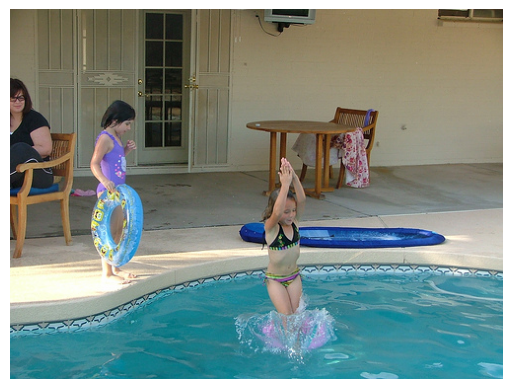



--------------------------------------------------
--------------------------------------------------
Image 2:
--------------------------------------------------
Actual Captions:

startseq brown dog leaps up to catch an orange toy endseq

startseq dog catches disk in the air endseq

startseq dog is jumping in the air to catch an orange frisbee endseq

startseq dog leaping to catch frisbee in the yard endseq

startseq brown dog leaping up with orange disc in mouth with blue and yellow toy boat in background endseq


Predicted Caption:
startseq dog jumps over touch frisbee endseq



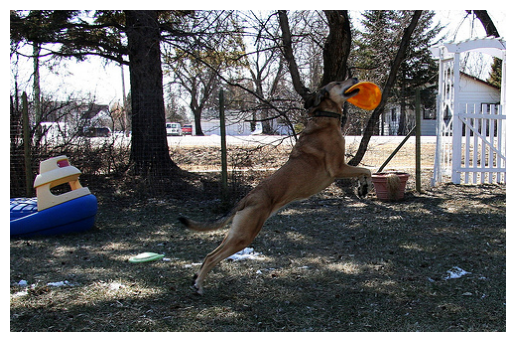



--------------------------------------------------
--------------------------------------------------
Image 3:
--------------------------------------------------
Actual Captions:

startseq boy in black shirt is inside structure with wooden ceiling beams endseq

startseq boy is playing in dark theater near the stage endseq

startseq male in black shirt near large curved archway endseq

startseq young boy in an empty hall with two others in the background endseq

startseq young man wearing black shirt looks down endseq


Predicted Caption:
startseq man in black shirt and cast in front of glass doors endseq



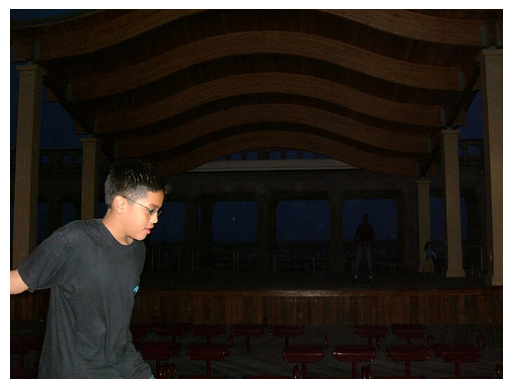



--------------------------------------------------
--------------------------------------------------
Image 4:
--------------------------------------------------
Actual Captions:

startseq beagle dog is walking on the shoreline at the beach endseq

startseq beagle walking on the beach next to some waves endseq

startseq beagle walks along the calm shore endseq

startseq the beagle is on beach walking along the shoreline endseq

startseq the beagle is walking on the beach at the waterline endseq


Predicted Caption:
startseq dog runs through the water endseq



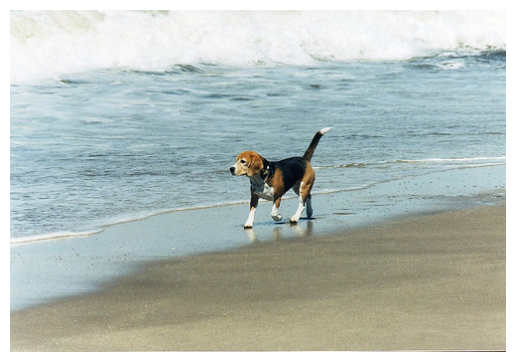



--------------------------------------------------
--------------------------------------------------
Image 5:
--------------------------------------------------
Actual Captions:

startseq boy jumps into the pool endseq

startseq an adult watches child somersault into the pool while another child looks on endseq

startseq woman throwing little boy into the pool endseq

startseq woman in blue is tossing young child into pool endseq

startseq woman throws little boy into pool as another boy watches endseq


Predicted Caption:
startseq little girl in blue bathing suit plays with water endseq



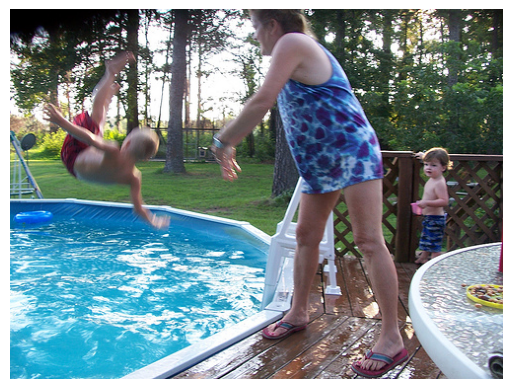



--------------------------------------------------


In [ ]:
import random

imgs = random.sample(list(test), 5)

for img in enumerate(imgs):
  print(f'-'*50)
  print(f"Image {img[0]+1}:")
  print(f'-'*50)
  generate_caption(img[1]+'.jpg')
  print('\n')
  print(f'-'*50)

## **Conclusion**

The BLEU scores achieved by the model are as follows:

**BLEU-1 (0.537991):** This score measure the overlap of unigrams (single words) between the predicted and actual captions. A score of 0.526 indicates a moderate level of similarity in terms of individual word overlap. While this suggests that the model is successfully generating captions with a reasonable number of correct words, there is still room for improvement in capturing the exact phrasing and meaning of the captions.

**BLEU-2 (0.309940):** This score measures the overlap of bigrams (pairs of consecutive words). A BLEU-2 score of 0.303 suggests that the model's predictions are somewhat less successful in capturing the relationships between pairs of words. This may indicate that while the model generates some correct words, it struggles to produce more complex and coherent sequences of words that accurately describe the image.

The BLEU-1 and BLEU-2 scores reflect that the model performs moderately well in generating image captions but still has significant room for improvement. The moderate BLEU-1 score suggests that the model is able to produce some correct individual words, but the lower BLEU-2 score indicates that it struggles to capture the more intricate relationships between words in the captions.

Overall, while the model provides reasonable results, it is clear that further enhancements are necessary to produce captions with higher quality and more linguistic coherence.